## Imports

In [1]:
import os
from typing import Tuple, Union

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn.functional as F
from pytorch_lightning import LightningModule, seed_everything
from torch import Tensor, nn
from torch.utils.data import DataLoader, random_split
from torchmetrics import Accuracy, F1Score, MetricCollection, Precision, Recall
from torchvision import transforms
from torchvision.datasets import MNIST

from energizer import Trainer
from energizer.query_strategies import (
    BALDStrategy,
    EntropyStrategy,
    LeastConfidenceStrategy,
    MarginStrategy,
    RandomStrategy,
)

## Data preparation

Load and preprocess data, and prepare dataloaders

In [2]:
data_dir = "./data"

preprocessing_pipe = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,)),
    ]
)

# create train and test sets
train_set = MNIST(data_dir, train=True, download=True, transform=preprocessing_pipe)
test_set = MNIST(data_dir, train=False, download=True, transform=preprocessing_pipe)

# train-val split to create a validation set
train_set, val_set = random_split(train_set, [55000, 5000])

# create dataloaders
batch_size = 32
eval_batch_size = 128  # this is use when evaluating on the pool too
num_workers = os.cpu_count()

# dataloaders
train_dl = DataLoader(train_set, batch_size=batch_size, num_workers=num_workers)
val_dl = DataLoader(val_set, batch_size=eval_batch_size, num_workers=num_workers)
test_dl = DataLoader(test_set, batch_size=eval_batch_size, num_workers=num_workers)

## Model definition
Define the model

In [3]:
class MNISTCNNModel(LightningModule):
    def __init__(self) -> None:
        """Here we define the model architecture and the metrics."""
        super().__init__()

        # create the CNN
        self.model = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout2d(),
            nn.Conv2d(32, 64, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout2d(),
            nn.Flatten(),
            nn.Linear(1024, 128),
            nn.Dropout(),
            nn.Linear(128, self.num_classes),
        )

        # implement metrics
        for stage in ("train", "val", "test"):
            metrics = MetricCollection(
                {
                    "accuracy": Accuracy(),
                    "precision_macro": Precision(
                        num_classes=self.num_classes, average="macro"
                    ),
                    "recall_macro": Recall(
                        num_classes=self.num_classes, average="macro"
                    ),
                    "f1_macro": F1Score(
                        num_classes=self.num_classes, average="macro"
                    ),
                    "f1_micro": F1Score(
                        num_classes=self.num_classes, average="micro"
                    ),
                }
            )
            setattr(self, f"{stage}_metrics", metrics)

    @property
    def num_classes(self) -> int:
        """This is very tailored to MNIST, so hard-code this propoerty."""
        return 10

    def get_inputs_from_batch(self, batch: Tuple[Tensor, Tensor]) -> Tensor:
        return batch[0]

    def forward(self, x: Tensor) -> Tensor:
        return self.model(x)

    def common_step(self, batch: Tuple[Tensor, Tensor], stage: str) -> Tensor:
        """For convenience define a common step."""

        # forward pass
        x, y = batch
        logits = self(x)

        # metrics
        loss = F.cross_entropy(logits, y)
        metrics = getattr(self, f"{stage}_metrics")(logits, y)

        # log
        self.log("loss", loss, on_step=False, on_epoch=True, prog_bar=False)
        self.log_dict(metrics, on_step=False, on_epoch=True, prog_bar=False)

        return loss

    def training_step(self, batch: Tuple[Tensor, Tensor], batch_idx: int) -> Tensor:
        return self.common_step(batch, "train")

    def validation_step(
        self, batch: Tuple[Tensor, Tensor], batch_idx: int
    ) -> Tensor:
        return self.common_step(batch, "val")

    def test_step(self, batch: Tuple[Tensor, Tensor], batch_idx: int) -> Tensor:
        return self.common_step(batch, "test")

    def configure_optimizers(self) -> None:
        return torch.optim.SGD(self.parameters(), lr=0.001)

## Active fit

Instantiate model

In [4]:
model = MNISTCNNModel()

!!! info "Batch unpacking"
    When passing a model to build a strategy, internally a `deepcopy` will be created. This is done to avoid modifying the model state and passing it around when trying other strategies. It avoids messing up states.

In [5]:
strategies = {
    "random": RandomStrategy(model),
    "leastconfidence": LeastConfidenceStrategy(model),
    "margin": MarginStrategy(model),
    "entropy": EntropyStrategy(model),
    "bald": BALDStrategy(model),
}

For clarity let's pack the trainer kwargs in a dictionary

In [6]:
trainer_kwargs = {
    "query_size": 10,  # new instances will be queried at each iteration
    "max_epochs": 3,  # the underlying model will be fit for 3 epochs
    "max_labelling_epochs": 2,  # how many times to run the active learning loop
    "accelerator": "cpu",  # use the gpu
    "test_after_labelling": True,  # since we have a test set, we test after each labelling iteration
    "limit_val_batches": 0,  # do not validate
    "log_every_n_steps": 1,  # we will have a few batches while training, so log on each
}

results_dict = {}

Run experiments

In [7]:
for name, strategy in strategies.items():
    seed_everything(42)  # for reproducibility (e.g., dropout)

    trainer = Trainer(**trainer_kwargs, enable_progress_bar=False)

    results = trainer.active_fit(
        model=strategy,
        train_dataloaders=train_dl,
        val_dataloaders=val_dl,
        test_dataloaders=test_dl,
    )

    results_dict[name] = results.to_pandas()

Global seed set to 42
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/lescipi/miniconda3/envs/energizer-dev/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1789: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(
[2022-09-26 17:46:39] energizer/INFO ~ trainer:269$ Trainer: trainer active_fit stage

  | Name          | Type             | Params
---------------------------------------------------
0 | model         | Sequential       | 184 K 
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | test_metrics  | MetricCollection | 0     
---------------------------------------------------
184 K     Trainable params
0         Non-trainable params
184 K     Total params
0.738     Total estimated model params size (MB)
[2022-09-26 17:46:39]

-------------------------Labelling Iteration 0--------------------------


[2022-09-26 17:46:39] energizer/DEBUG ~ trainer:470$ Using underlying `MNISTCNNModel`


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         accuracy          │    0.12139999866485596    │
│         f1_macro          │    0.05989480018615723    │
│         f1_micro          │    0.12139999866485596    │
│           loss            │     2.302485466003418     │
│      precision_macro      │   0.050614677369594574    │
│       recall_macro        │    0.1247788593173027     │
└───────────────────────────┴───────────────────────────┘

[2022-09-26 17:46:41] energizer/DEBUG ~ trainer:466$ Using `RandomStrategy`
[2022-09-26 17:46:41] energizer/INFO ~ active_learning_loop:193$ Queried 10 instance
[2022-09-26 17:46:41] energizer/INFO ~ active_learning_loop:281$ Annotated 10 instances
[2022-09-26 17:46:41] energizer/INFO ~ active_learning_loop:282$ New data statistics
num_pool_batches: 430
num_train_batches: 1
pool_size: 54990
total_data_size: 55000
train_size: 10



-------------------------Labelling Iteration 1--------------------------


[2022-09-26 17:46:41] energizer/DEBUG ~ trainer:470$ Using underlying `MNISTCNNModel`
[2022-09-26 17:46:41] energizer/DEBUG ~ active_learning_loop:250$ MNISTCNNModel state dict has been re-initialized
`Trainer.fit` stopped: `max_epochs=3` reached.
[2022-09-26 17:46:46] energizer/DEBUG ~ trainer:470$ Using underlying `MNISTCNNModel`


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         accuracy          │    0.12540000677108765    │
│         f1_macro          │   0.050436750054359436    │
│         f1_micro          │    0.12540000677108765    │
│           loss            │     2.302597761154175     │
│      precision_macro      │   0.033808622509241104    │
│       recall_macro        │    0.12841922044754028    │
└───────────────────────────┴───────────────────────────┘

[2022-09-26 17:46:49] energizer/DEBUG ~ trainer:466$ Using `RandomStrategy`
[2022-09-26 17:46:49] energizer/INFO ~ active_learning_loop:193$ Queried 10 instance
[2022-09-26 17:46:49] energizer/INFO ~ active_learning_loop:281$ Annotated 10 instances
[2022-09-26 17:46:49] energizer/INFO ~ active_learning_loop:282$ New data statistics
num_pool_batches: 430
num_train_batches: 1
pool_size: 54980
total_data_size: 55000
train_size: 20

[2022-09-26 17:46:49] energizer/DEBUG ~ trainer:470$ Using underlying `MNISTCNNModel`
[2022-09-26 17:46:49] energizer/DEBUG ~ active_learning_loop:250$ MNISTCNNModel state dict has been re-initialized


-----------------------------Last fit_loop------------------------------


`Trainer.fit` stopped: `max_epochs=3` reached.
[2022-09-26 17:46:54] energizer/DEBUG ~ trainer:470$ Using underlying `MNISTCNNModel`


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         accuracy          │    0.1378999948501587     │
│         f1_macro          │    0.06494041532278061    │
│         f1_micro          │    0.1378999948501587     │
│           loss            │     2.301481008529663     │
│      precision_macro      │   0.044325053691864014    │
│       recall_macro        │    0.1415809839963913     │
└───────────────────────────┴───────────────────────────┘

[2022-09-26 17:46:57] energizer/DEBUG ~ trainer:466$ Using `RandomStrategy`
Global seed set to 42
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/lescipi/miniconda3/envs/energizer-dev/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1789: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(
[2022-09-26 17:46:58] energizer/INFO ~ trainer:269$ Trainer: trainer active_fit stage

  | Name          | Type             | Params
---------------------------------------------------
0 | model         | Sequential       | 184 K 
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | test_metrics  | MetricCollection | 0     
---------------------------------------------------
184 K     Trainable params
0         Non-trainable params
184 K     Total p

-------------------------Labelling Iteration 0--------------------------


[2022-09-26 17:46:58] energizer/DEBUG ~ trainer:470$ Using underlying `MNISTCNNModel`


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         accuracy          │    0.12139999866485596    │
│         f1_macro          │    0.05989480018615723    │
│         f1_micro          │    0.12139999866485596    │
│           loss            │     2.302485466003418     │
│      precision_macro      │   0.050614677369594574    │
│       recall_macro        │    0.1247788593173027     │
└───────────────────────────┴───────────────────────────┘

[2022-09-26 17:47:00] energizer/DEBUG ~ trainer:466$ Using `LeastConfidenceStrategy`
[2022-09-26 17:47:10] energizer/INFO ~ active_learning_loop:193$ Queried 10 instance
[2022-09-26 17:47:10] energizer/INFO ~ active_learning_loop:281$ Annotated 10 instances
[2022-09-26 17:47:10] energizer/INFO ~ active_learning_loop:282$ New data statistics
num_pool_batches: 430
num_train_batches: 1
pool_size: 54990
total_data_size: 55000
train_size: 10



-------------------------Labelling Iteration 1--------------------------


[2022-09-26 17:47:10] energizer/DEBUG ~ trainer:470$ Using underlying `MNISTCNNModel`
[2022-09-26 17:47:10] energizer/DEBUG ~ active_learning_loop:250$ MNISTCNNModel state dict has been re-initialized
`Trainer.fit` stopped: `max_epochs=3` reached.
[2022-09-26 17:47:15] energizer/DEBUG ~ trainer:470$ Using underlying `MNISTCNNModel`


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         accuracy          │    0.12439999729394913    │
│         f1_macro          │    0.05229624733328819    │
│         f1_micro          │    0.12439999729394913    │
│           loss            │    2.3006510734558105     │
│      precision_macro      │    0.03502652049064636    │
│       recall_macro        │    0.12720972299575806    │
└───────────────────────────┴───────────────────────────┘

[2022-09-26 17:47:18] energizer/DEBUG ~ trainer:466$ Using `LeastConfidenceStrategy`
[2022-09-26 17:47:28] energizer/INFO ~ active_learning_loop:193$ Queried 10 instance
[2022-09-26 17:47:28] energizer/INFO ~ active_learning_loop:281$ Annotated 10 instances
[2022-09-26 17:47:28] energizer/INFO ~ active_learning_loop:282$ New data statistics
num_pool_batches: 430
num_train_batches: 1
pool_size: 54980
total_data_size: 55000
train_size: 20

[2022-09-26 17:47:28] energizer/DEBUG ~ trainer:470$ Using underlying `MNISTCNNModel`
[2022-09-26 17:47:28] energizer/DEBUG ~ active_learning_loop:250$ MNISTCNNModel state dict has been re-initialized


-----------------------------Last fit_loop------------------------------


`Trainer.fit` stopped: `max_epochs=3` reached.
[2022-09-26 17:47:34] energizer/DEBUG ~ trainer:470$ Using underlying `MNISTCNNModel`


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         accuracy          │    0.1298999935388565     │
│         f1_macro          │   0.058535393327474594    │
│         f1_micro          │    0.1298999935388565     │
│           loss            │     2.299091100692749     │
│      precision_macro      │   0.039099011570215225    │
│       recall_macro        │    0.1328250616788864     │
└───────────────────────────┴───────────────────────────┘

[2022-09-26 17:47:37] energizer/DEBUG ~ trainer:466$ Using `LeastConfidenceStrategy`
Global seed set to 42
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/lescipi/miniconda3/envs/energizer-dev/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1789: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(
[2022-09-26 17:47:37] energizer/INFO ~ trainer:269$ Trainer: trainer active_fit stage

  | Name          | Type             | Params
---------------------------------------------------
0 | model         | Sequential       | 184 K 
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | test_metrics  | MetricCollection | 0     
---------------------------------------------------
184 K     Trainable params
0         Non-trainable params
184 K   

-------------------------Labelling Iteration 0--------------------------


[2022-09-26 17:47:37] energizer/DEBUG ~ trainer:470$ Using underlying `MNISTCNNModel`


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         accuracy          │    0.12139999866485596    │
│         f1_macro          │    0.05989480018615723    │
│         f1_micro          │    0.12139999866485596    │
│           loss            │     2.302485466003418     │
│      precision_macro      │   0.050614677369594574    │
│       recall_macro        │    0.1247788593173027     │
└───────────────────────────┴───────────────────────────┘

[2022-09-26 17:47:40] energizer/DEBUG ~ trainer:466$ Using `MarginStrategy`
[2022-09-26 17:47:49] energizer/INFO ~ active_learning_loop:193$ Queried 10 instance
[2022-09-26 17:47:49] energizer/INFO ~ active_learning_loop:281$ Annotated 10 instances
[2022-09-26 17:47:49] energizer/INFO ~ active_learning_loop:282$ New data statistics
num_pool_batches: 430
num_train_batches: 1
pool_size: 54990
total_data_size: 55000
train_size: 10



-------------------------Labelling Iteration 1--------------------------


[2022-09-26 17:47:49] energizer/DEBUG ~ trainer:470$ Using underlying `MNISTCNNModel`
[2022-09-26 17:47:49] energizer/DEBUG ~ active_learning_loop:250$ MNISTCNNModel state dict has been re-initialized
`Trainer.fit` stopped: `max_epochs=3` reached.
[2022-09-26 17:47:54] energizer/DEBUG ~ trainer:470$ Using underlying `MNISTCNNModel`


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         accuracy          │    0.11969999969005585    │
│         f1_macro          │   0.054541368037462234    │
│         f1_micro          │    0.11969999969005585    │
│           loss            │     2.29711651802063      │
│      precision_macro      │   0.045692265033721924    │
│       recall_macro        │    0.12266905605792999    │
└───────────────────────────┴───────────────────────────┘

[2022-09-26 17:47:57] energizer/DEBUG ~ trainer:466$ Using `MarginStrategy`
[2022-09-26 17:48:07] energizer/INFO ~ active_learning_loop:193$ Queried 10 instance
[2022-09-26 17:48:07] energizer/INFO ~ active_learning_loop:281$ Annotated 10 instances
[2022-09-26 17:48:07] energizer/INFO ~ active_learning_loop:282$ New data statistics
num_pool_batches: 430
num_train_batches: 1
pool_size: 54980
total_data_size: 55000
train_size: 20

[2022-09-26 17:48:07] energizer/DEBUG ~ trainer:470$ Using underlying `MNISTCNNModel`
[2022-09-26 17:48:07] energizer/DEBUG ~ active_learning_loop:250$ MNISTCNNModel state dict has been re-initialized


-----------------------------Last fit_loop------------------------------


`Trainer.fit` stopped: `max_epochs=3` reached.
[2022-09-26 17:48:13] energizer/DEBUG ~ trainer:470$ Using underlying `MNISTCNNModel`


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         accuracy          │    0.11890000104904175    │
│         f1_macro          │    0.05812247842550278    │
│         f1_micro          │    0.11890000104904175    │
│           loss            │    2.2988967895507812     │
│      precision_macro      │   0.054246868938207626    │
│       recall_macro        │    0.12245862185955048    │
└───────────────────────────┴───────────────────────────┘

[2022-09-26 17:48:16] energizer/DEBUG ~ trainer:466$ Using `MarginStrategy`
Global seed set to 42
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/lescipi/miniconda3/envs/energizer-dev/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1789: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(
[2022-09-26 17:48:16] energizer/INFO ~ trainer:269$ Trainer: trainer active_fit stage

  | Name          | Type             | Params
---------------------------------------------------
0 | model         | Sequential       | 184 K 
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | test_metrics  | MetricCollection | 0     
---------------------------------------------------
184 K     Trainable params
0         Non-trainable params
184 K     Total p

-------------------------Labelling Iteration 0--------------------------


[2022-09-26 17:48:16] energizer/DEBUG ~ trainer:470$ Using underlying `MNISTCNNModel`


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         accuracy          │    0.12139999866485596    │
│         f1_macro          │    0.05989480018615723    │
│         f1_micro          │    0.12139999866485596    │
│           loss            │     2.302485466003418     │
│      precision_macro      │   0.050614677369594574    │
│       recall_macro        │    0.1247788593173027     │
└───────────────────────────┴───────────────────────────┘

[2022-09-26 17:48:19] energizer/DEBUG ~ trainer:466$ Using `EntropyStrategy`
[2022-09-26 17:48:28] energizer/INFO ~ active_learning_loop:193$ Queried 10 instance
[2022-09-26 17:48:28] energizer/INFO ~ active_learning_loop:281$ Annotated 10 instances
[2022-09-26 17:48:28] energizer/INFO ~ active_learning_loop:282$ New data statistics
num_pool_batches: 430
num_train_batches: 1
pool_size: 54990
total_data_size: 55000
train_size: 10



-------------------------Labelling Iteration 1--------------------------


[2022-09-26 17:48:28] energizer/DEBUG ~ trainer:470$ Using underlying `MNISTCNNModel`
[2022-09-26 17:48:28] energizer/DEBUG ~ active_learning_loop:250$ MNISTCNNModel state dict has been re-initialized
`Trainer.fit` stopped: `max_epochs=3` reached.
[2022-09-26 17:48:34] energizer/DEBUG ~ trainer:470$ Using underlying `MNISTCNNModel`


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         accuracy          │    0.12999999523162842    │
│         f1_macro          │    0.06347090005874634    │
│         f1_micro          │    0.12999999523162842    │
│           loss            │    2.2974393367767334     │
│      precision_macro      │   0.046992816030979156    │
│       recall_macro        │    0.1336027979850769     │
└───────────────────────────┴───────────────────────────┘

[2022-09-26 17:48:36] energizer/DEBUG ~ trainer:466$ Using `EntropyStrategy`
[2022-09-26 17:48:46] energizer/INFO ~ active_learning_loop:193$ Queried 10 instance
[2022-09-26 17:48:46] energizer/INFO ~ active_learning_loop:281$ Annotated 10 instances
[2022-09-26 17:48:46] energizer/INFO ~ active_learning_loop:282$ New data statistics
num_pool_batches: 430
num_train_batches: 1
pool_size: 54980
total_data_size: 55000
train_size: 20

[2022-09-26 17:48:46] energizer/DEBUG ~ trainer:470$ Using underlying `MNISTCNNModel`
[2022-09-26 17:48:46] energizer/DEBUG ~ active_learning_loop:250$ MNISTCNNModel state dict has been re-initialized


-----------------------------Last fit_loop------------------------------


`Trainer.fit` stopped: `max_epochs=3` reached.
[2022-09-26 17:48:52] energizer/DEBUG ~ trainer:470$ Using underlying `MNISTCNNModel`


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         accuracy          │    0.12530000507831573    │
│         f1_macro          │    0.06157331541180611    │
│         f1_micro          │    0.12530000507831573    │
│           loss            │     2.297584295272827     │
│      precision_macro      │    0.04746979475021362    │
│       recall_macro        │    0.1287963092327118     │
└───────────────────────────┴───────────────────────────┘

[2022-09-26 17:48:55] energizer/DEBUG ~ trainer:466$ Using `EntropyStrategy`
Global seed set to 42
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/lescipi/miniconda3/envs/energizer-dev/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1789: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(
[2022-09-26 17:48:55] energizer/INFO ~ trainer:269$ Trainer: trainer active_fit stage

  | Name          | Type             | Params
---------------------------------------------------
0 | model         | Sequential       | 184 K 
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | test_metrics  | MetricCollection | 0     
---------------------------------------------------
184 K     Trainable params
0         Non-trainable params
184 K     Total 

-------------------------Labelling Iteration 0--------------------------


[2022-09-26 17:48:55] energizer/DEBUG ~ trainer:470$ Using underlying `MNISTCNNModel`


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         accuracy          │    0.09989999979734421    │
│         f1_macro          │    0.07487398386001587    │
│         f1_micro          │    0.09989999979734421    │
│           loss            │     2.383131742477417     │
│      precision_macro      │    0.09914936870336533    │
│       recall_macro        │    0.10110820829868317    │
└───────────────────────────┴───────────────────────────┘

[2022-09-26 17:48:57] energizer/DEBUG ~ trainer:466$ Using `BALDStrategy`
[2022-09-26 17:49:59] energizer/INFO ~ active_learning_loop:193$ Queried 10 instance
[2022-09-26 17:49:59] energizer/INFO ~ active_learning_loop:281$ Annotated 10 instances
[2022-09-26 17:49:59] energizer/INFO ~ active_learning_loop:282$ New data statistics
num_pool_batches: 430
num_train_batches: 1
pool_size: 54990
total_data_size: 55000
train_size: 10



-------------------------Labelling Iteration 1--------------------------


[2022-09-26 17:49:59] energizer/DEBUG ~ trainer:470$ Using underlying `MNISTCNNModel`
[2022-09-26 17:49:59] energizer/DEBUG ~ active_learning_loop:250$ MNISTCNNModel state dict has been re-initialized
`Trainer.fit` stopped: `max_epochs=3` reached.
[2022-09-26 17:50:04] energizer/DEBUG ~ trainer:470$ Using underlying `MNISTCNNModel`


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         accuracy          │    0.10409999638795853    │
│         f1_macro          │    0.07243089377880096    │
│         f1_micro          │    0.10409999638795853    │
│           loss            │     2.390538215637207     │
│      precision_macro      │    0.10765033960342407    │
│       recall_macro        │    0.1064007356762886     │
└───────────────────────────┴───────────────────────────┘

[2022-09-26 17:50:08] energizer/DEBUG ~ trainer:466$ Using `BALDStrategy`
[2022-09-26 17:51:22] energizer/INFO ~ active_learning_loop:193$ Queried 10 instance
[2022-09-26 17:51:22] energizer/INFO ~ active_learning_loop:281$ Annotated 10 instances
[2022-09-26 17:51:22] energizer/INFO ~ active_learning_loop:282$ New data statistics
num_pool_batches: 430
num_train_batches: 1
pool_size: 54980
total_data_size: 55000
train_size: 20

[2022-09-26 17:51:22] energizer/DEBUG ~ trainer:470$ Using underlying `MNISTCNNModel`
[2022-09-26 17:51:22] energizer/DEBUG ~ active_learning_loop:250$ MNISTCNNModel state dict has been re-initialized


-----------------------------Last fit_loop------------------------------


`Trainer.fit` stopped: `max_epochs=3` reached.
[2022-09-26 17:51:27] energizer/DEBUG ~ trainer:470$ Using underlying `MNISTCNNModel`


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         accuracy          │    0.10339999943971634    │
│         f1_macro          │    0.07382594794034958    │
│         f1_micro          │    0.10339999943971634    │
│           loss            │     2.378535270690918     │
│      precision_macro      │    0.10162188857793808    │
│       recall_macro        │    0.10477112978696823    │
└───────────────────────────┴───────────────────────────┘

[2022-09-26 17:51:30] energizer/DEBUG ~ trainer:466$ Using `BALDStrategy`


## Results
Now let's look at the results

In [48]:
results_df = pd.concat([v.assign(query_strategy=k) for k, v in results_dict.items()])
results_df = results_df.melt(
    id_vars=["train_size", "query_strategy"], var_name="metrics"
)

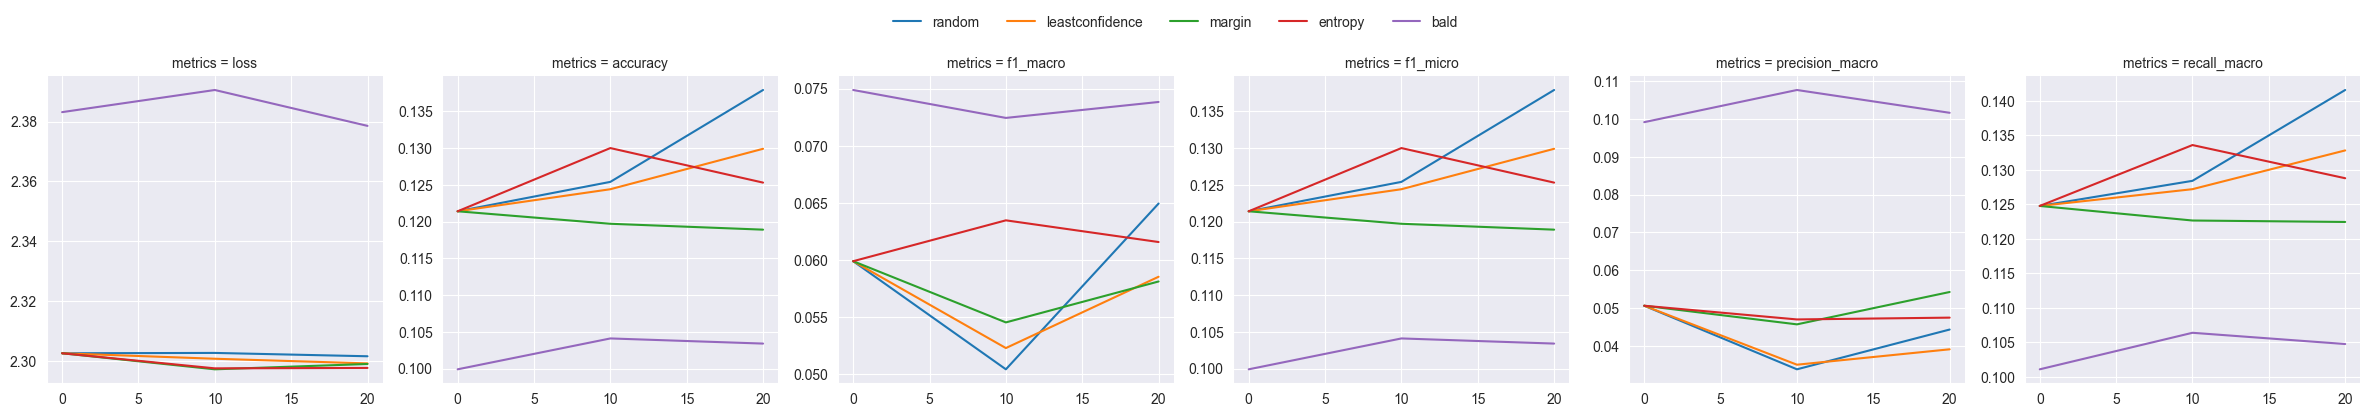

In [87]:
import warnings

with warnings.catch_warnings():
    warnings.simplefilter('ignore')

    sns.set_style("darkgrid")
    g = sns.FacetGrid(
        data=results_df,
        col="metrics",
        sharex=True,
        sharey=False,
        height=4,
        hue="query_strategy",
        legend_out=False,
    )
    p = g.map(sns.lineplot, "train_size", "value")
    p = p.add_legend()
    sns.move_legend(
        p,
        "lower center",
        bbox_to_anchor=(0.5, 1),
        ncol=5,
        title=None,
        frameon=False,
    )
    p.set(ylabel=None, xlabel=None)